<a href="https://colab.research.google.com/github/engineercha/engineercha/blob/master/%EA%B8%B0%EA%B3%84%EC%8B%9C%EC%84%A4%EB%AC%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 데이터 구조

2020-02-125.기계시설물고장예지_sample

> current
>>2.2kW
>>>L-DSF-01 정상, 축정렬불량  
>>>L-EF-04 정상, 회전체불평형  
>>>L-SF-04 정상, 베어링불량  
>>>R-EF-05 정상, 벨트느슨함  

>>55kW  
>>>L-PAHU-03S 정상, 회전체불평형  
>>>R-PAHU-04S 정상, 벨트느슨함  

>vibration
>>2.2kW  
>>55kW

In [1]:
import numpy as np
import pandas as pd
import os
import unicodedata
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import pickle

In [2]:
from google.colab import drive 
drive.mount('/content/gdrive/')
file_path = "/content/gdrive/MyDrive/data/2020-02-125.기계시설물고장예지_sample/"
drive = '/content/gdrive/MyDrive/'

Mounted at /content/gdrive/


#### 데이터 불러오기

In [3]:
def load(corv):
  if corv not in ['current','vibration']: return None
  df_정상=pd.DataFrame() 
  df_고장=pd.DataFrame()
  i=1
  for machine in os.listdir(file_path+corv+'/2.2kW'):
      for types in os.listdir(file_path+corv+'/2.2kW/'+machine):
        for files in os.listdir(file_path+corv+'/2.2kW/'+machine+'/'+types):
          tmp=pd.read_csv(file_path+corv+'/2.2kW/'+machine+'/'+types+'/'+files, skiprows=9, header=None)
          if corv=='current': tmp=tmp.drop([0, 4],axis=1)
          elif corv=='vibration': tmp=tmp.drop([0, 2],axis=1)
          tmp=tmp.transpose()

          types=unicodedata.normalize('NFC', types)
          if types=='정상': df_정상=pd.concat([df, tmp])
          else: df_고장=pd.concat([df, tmp])

          if i==1:
            res=machine+' '+types 
            print(i, res)
          elif res!=machine+' '+types: 
            res=machine+' '+types
            print(i, res)
          i+=1

  df_정상=df_정상.reset_index().drop(['index'], axis=1)
  df_고장=df_고장.reset_index().drop(['index'], axis=1)

  return df_정상, df_고장

In [62]:
#정상/고장 데이터 불러오기

a=pd.read_pickle(os.path.join(drive, '전류정상.pkl'))
b=pd.read_pickle(os.path.join(drive, '전류고장.pkl'))

print(a.shape, b.shape)

(2718, 2000) (2937, 2000)


#### 데이터 전처리

변수가 많아서 미리 좀 설명하자면 

일단 정상은 a에 고장은 b에 저장해뒀어

오토인코더는 오늘 말했듯이 정상데이터만 갖고 학습을 하기 때문에

a만 a_train, a_test로 나누고

b는 b_test만 만들어줬어

이때, test에 쓸 데이터니까 섞어주는 게 좋을 것 같아서 pandas에서 데이터프레임 행 섞는 함수인 sample 추가해줬어

**train 데이터는 이게 끝임**

이 뒤는 우리가 그동안 했던 거랑 똑같음

a_test_tot이랑 b_test_tot은 x데이터에 라벨까지 합친 데이터프레임이고,

test_tot은 그 둘을 합친 데이터셋임

**valid랑 test 데이터는 train_test_split()으로 만들어줌**








1. 훈련/검증/테스트 분리

In [63]:
#정상/고장의 train/test 분리

a_train, a_test = a[:2265], a[2265:]
b_test = b.sample(frac=1)[:453]


#test 데이터셋 만듦

a_test_tot = np.hstack((a_test, np.zeros(a_test.shape[0]).reshape(-1,1)))
b_test_tot = np.hstack((b_test, np.ones(b_test.shape[0]).reshape(-1,1)))

test = np.vstack((a_test_tot, b_test_tot)) #둘을 하나로 합침

#test 데이터셋의 검증/테스트 분리

x_test, x_valid, y_test, y_valid = train_test_split(test[:,:-1], test[:,-1], test_size=0.3, random_state=0)

print(x_test.shape, y_test.shape)
print(x_valid.shape, y_valid.shape)

2. 정규화

In [68]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

stder = StandardScaler()
stder.fit(a_train) #stder를 a_train에 맞춤

a_train_scaled = stder.transform(a_train)
x_test_scaled = stder.transform(x_test)
x_valid_scaled = stder.transform(x_valid)

print(a_train_scaled.shape)
print(x_test_scaled.shape)
print(x_valid_scaled.shape)

3. 스케일링

train/valid/test 데이터를 lstm 입력 형태로 맞추기 위해 3차원으로 차원을 변경함

In [70]:
# 복잡해 보이는거지 간단함

# X_scaled = X.reshape( X.shape[0], 1, X.shape[1] )

a_train_scaled = a_train_scaled.reshape(a_train_scaled.shape[0], 1, a_train_scaled.shape[1])
x_valid_scaled = x_valid_scaled.reshape(x_valid_scaled.shape[0], 1, x_valid_scaled.shape[1])
x_test_scaled = x_test_scaled.reshape(x_test_scaled.shape[0], 1, x_test_scaled.shape[1])

print(a_train_scaled.shape)
print(x_test_scaled.shape)
print(x_valid_scaled.shape)

(2265, 1, 2000)
(634, 1, 2000)
(272, 1, 2000)


#### 모델 구현

In [94]:
from keras import regularizers
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model

def AE(x):
  inputs = Input(shape=(x.shape[1], x.shape[2]))

  L1=LSTM(140, activation='relu', return_sequences=True,
          kernel_regularizer=regularizers.l2(0.00))(inputs)

  L2=LSTM(70, activation='relu', return_sequences=False)(L1)

  L3=RepeatVector(x.shape[1])(L2)

  L4=LSTM(70, activation='relu', return_sequences=True)(L3)

  L5=LSTM(140, activation='relu', return_sequences=True)(L4)

  output = TimeDistributed(Dense(x.shape[2]))(L5)

  model = Model(inputs=inputs, outputs=output)

  return model

In [95]:
#모델 생성하고 컴파일

model = AE(a_train_scaled)

model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 1, 2000)]         0         
                                                                 
 lstm_16 (LSTM)              (None, 1, 140)            1198960   
                                                                 
 lstm_17 (LSTM)              (None, 70)                59080     
                                                                 
 repeat_vector_4 (RepeatVect  (None, 1, 70)            0         
 or)                                                             
                                                                 
 lstm_18 (LSTM)              (None, 1, 70)             39480     
                                                                 
 lstm_19 (LSTM)              (None, 1, 140)            118160    
                                                             

#### 모델 학습

나는 5분 20초 정도 걸림

In [106]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [EarlyStopping(monitor='val_loss', patience=5)]

history = model.fit(a_train_scaled, a_train_scaled, epochs=100, batch_size=32, callbacks=callbacks)

Epoch 1/100
71/71 [==============================] - ETA: 0s - loss: 0.0028

71/71 [==============================] - 4s 60ms/step - loss: 0.0028
Epoch 2/100
70/71 [============================>.] - ETA: 0s - loss: 0.0029

71/71 [==============================] - 3s 42ms/step - loss: 0.0029
Epoch 3/100
71/71 [==============================] - ETA: 0s - loss: 0.0034

71/71 [==============================] - 2s 34ms/step - loss: 0.0034
Epoch 4/100
71/71 [==============================] - ETA: 0s - loss: 0.0031

71/71 [==============================] - 3s 49ms/step - loss: 0.0031
Epoch 5/100
71/71 [==============================] - ETA: 0s - loss: 0.0029

71/71 [==============================] - 3s 38ms/step - loss: 0.0029
Epoch 6/100
71/71 [==============================] - ETA: 0s - loss: 0.0028

71/71 [==============================] - 2s 34ms/step - loss: 0.0028
Epoch 7/100
71/71 [==============================] - ETA: 0s - loss: 0.0028

71/71 [==============================] - 2s 34ms/step - loss: 0.0028
Epoch 8/100
70/71 [============================>.] - ETA: 0s - loss: 0.0030

71/71 [==============================] - 2s 34ms/step - loss: 0.0030
Epoch 9/100
71/71 [==============================] - ETA: 0s - loss: 0.0028

71/71 [==============================] - 3s 44ms/step - loss: 0.0028
Epoch 10/100
71/71 [==============================] - ETA: 0s - loss: 0.0027

71/71 [==============================] - 5s 64ms/step - loss: 0.0027
Epoch 11/100
71/71 [==============================] - ETA: 0s - loss: 0.0026

71/71 [==============================] - 4s 49ms/step - loss: 0.0026
Epoch 12/100
71/71 [==============================] - ETA: 0s - loss: 0.0027

71/71 [==============================] - 2s 35ms/step - loss: 0.0027
Epoch 13/100
70/71 [============================>.] - ETA: 0s - loss: 0.0027

71/71 [==============================] - 2s 35ms/step - loss: 0.0027
Epoch 14/100
71/71 [==============================] - ETA: 0s - loss: 0.0026

71/71 [==============================] - 5s 64ms/step - loss: 0.0026
Epoch 15/100
71/71 [==============================] - ETA: 0s - loss: 0.0028

71/71 [==============================] - 3s 47ms/step - loss: 0.0028
Epoch 16/100
71/71 [==============================] - ETA: 0s - loss: 0.0030

71/71 [==============================] - 3s 40ms/step - loss: 0.0030
Epoch 17/100
70/71 [============================>.] - ETA: 0s - loss: 0.0030

71/71 [==============================] - 2s 33ms/step - loss: 0.0030
Epoch 18/100
71/71 [==============================] - ETA: 0s - loss: 0.0030

71/71 [==============================] - 3s 35ms/step - loss: 0.0030
Epoch 19/100
71/71 [==============================] - ETA: 0s - loss: 0.0026

71/71 [==============================] - 4s 52ms/step - loss: 0.0026
Epoch 20/100
70/71 [============================>.] - ETA: 0s - loss: 0.0028

71/71 [==============================] - 3s 36ms/step - loss: 0.0028
Epoch 21/100
71/71 [==============================] - ETA: 0s - loss: 0.0026

71/71 [==============================] - 2s 34ms/step - loss: 0.0026
Epoch 22/100
70/71 [============================>.] - ETA: 0s - loss: 0.0025

71/71 [==============================] - 2s 34ms/step - loss: 0.0025
Epoch 23/100
71/71 [==============================] - ETA: 0s - loss: 0.0027

71/71 [==============================] - 2s 34ms/step - loss: 0.0027
Epoch 24/100
71/71 [==============================] - ETA: 0s - loss: 0.0028

71/71 [==============================] - 4s 58ms/step - loss: 0.0028
Epoch 25/100
71/71 [==============================] - ETA: 0s - loss: 0.0028

71/71 [==============================] - 4s 53ms/step - loss: 0.0028
Epoch 26/100
71/71 [==============================] - ETA: 0s - loss: 0.0026

71/71 [==============================] - 2s 34ms/step - loss: 0.0026
Epoch 27/100
71/71 [==============================] - ETA: 0s - loss: 0.0025

71/71 [==============================] - 2s 34ms/step - loss: 0.0025
Epoch 28/100
71/71 [==============================] - ETA: 0s - loss: 0.0026

71/71 [==============================] - 2s 33ms/step - loss: 0.0026
Epoch 29/100
71/71 [==============================] - ETA: 0s - loss: 0.0026

71/71 [==============================] - 4s 58ms/step - loss: 0.0026
Epoch 30/100
71/71 [==============================] - ETA: 0s - loss: 0.0028

71/71 [==============================] - 4s 63ms/step - loss: 0.0028
Epoch 31/100
71/71 [==============================] - ETA: 0s - loss: 0.0030

71/71 [==============================] - 3s 38ms/step - loss: 0.0030
Epoch 32/100
71/71 [==============================] - ETA: 0s - loss: 0.0028

71/71 [==============================] - 4s 58ms/step - loss: 0.0028
Epoch 33/100
70/71 [============================>.] - ETA: 0s - loss: 0.0026

71/71 [==============================] - 5s 71ms/step - loss: 0.0026
Epoch 34/100
70/71 [============================>.] - ETA: 0s - loss: 0.0025

71/71 [==============================] - 2s 34ms/step - loss: 0.0025
Epoch 35/100
71/71 [==============================] - ETA: 0s - loss: 0.0026

71/71 [==============================] - 3s 49ms/step - loss: 0.0026
Epoch 36/100
71/71 [==============================] - ETA: 0s - loss: 0.0028

71/71 [==============================] - 4s 50ms/step - loss: 0.0028
Epoch 37/100
70/71 [============================>.] - ETA: 0s - loss: 0.0028

71/71 [==============================] - 3s 49ms/step - loss: 0.0028
Epoch 38/100
71/71 [==============================] - ETA: 0s - loss: 0.0026

71/71 [==============================] - 3s 40ms/step - loss: 0.0026
Epoch 39/100
70/71 [============================>.] - ETA: 0s - loss: 0.0025

71/71 [==============================] - 3s 35ms/step - loss: 0.0025
Epoch 40/100
70/71 [============================>.] - ETA: 0s - loss: 0.0029

71/71 [==============================] - 2s 35ms/step - loss: 0.0029
Epoch 41/100
71/71 [==============================] - ETA: 0s - loss: 0.0029

71/71 [==============================] - 3s 40ms/step - loss: 0.0029
Epoch 42/100
71/71 [==============================] - ETA: 0s - loss: 0.0027

71/71 [==============================] - 5s 67ms/step - loss: 0.0027
Epoch 43/100
70/71 [============================>.] - ETA: 0s - loss: 0.0027

71/71 [==============================] - 4s 50ms/step - loss: 0.0027
Epoch 44/100
71/71 [==============================] - ETA: 0s - loss: 0.0026

71/71 [==============================] - 4s 53ms/step - loss: 0.0026
Epoch 45/100
71/71 [==============================] - ETA: 0s - loss: 0.0025

71/71 [==============================] - 2s 34ms/step - loss: 0.0025
Epoch 46/100
71/71 [==============================] - ETA: 0s - loss: 0.0026

71/71 [==============================] - 4s 53ms/step - loss: 0.0026
Epoch 47/100
71/71 [==============================] - ETA: 0s - loss: 0.0028

71/71 [==============================] - 5s 69ms/step - loss: 0.0028
Epoch 48/100
71/71 [==============================] - ETA: 0s - loss: 0.0027

71/71 [==============================] - 4s 52ms/step - loss: 0.0027
Epoch 49/100
71/71 [==============================] - ETA: 0s - loss: 0.0025

71/71 [==============================] - 3s 47ms/step - loss: 0.0025
Epoch 50/100
71/71 [==============================] - ETA: 0s - loss: 0.0025

71/71 [==============================] - 5s 66ms/step - loss: 0.0025
Epoch 51/100
71/71 [==============================] - ETA: 0s - loss: 0.0025

71/71 [==============================] - 4s 51ms/step - loss: 0.0025
Epoch 52/100
71/71 [==============================] - ETA: 0s - loss: 0.0024

71/71 [==============================] - 4s 55ms/step - loss: 0.0024
Epoch 53/100
71/71 [==============================] - ETA: 0s - loss: 0.0025

71/71 [==============================] - 2s 34ms/step - loss: 0.0025
Epoch 54/100
71/71 [==============================] - ETA: 0s - loss: 0.0026

71/71 [==============================] - 3s 49ms/step - loss: 0.0026
Epoch 55/100
71/71 [==============================] - ETA: 0s - loss: 0.0026

71/71 [==============================] - 3s 40ms/step - loss: 0.0026
Epoch 56/100
70/71 [============================>.] - ETA: 0s - loss: 0.0027

71/71 [==============================] - 2s 34ms/step - loss: 0.0027
Epoch 57/100
71/71 [==============================] - ETA: 0s - loss: 0.0029

71/71 [==============================] - 2s 34ms/step - loss: 0.0029
Epoch 58/100
71/71 [==============================] - ETA: 0s - loss: 0.0027

71/71 [==============================] - 2s 34ms/step - loss: 0.0027
Epoch 59/100
71/71 [==============================] - ETA: 0s - loss: 0.0026

71/71 [==============================] - 3s 43ms/step - loss: 0.0026
Epoch 60/100
70/71 [============================>.] - ETA: 0s - loss: 0.0026

71/71 [==============================] - 3s 46ms/step - loss: 0.0026
Epoch 61/100
71/71 [==============================] - ETA: 0s - loss: 0.0025

71/71 [==============================] - 2s 34ms/step - loss: 0.0025
Epoch 62/100
70/71 [============================>.] - ETA: 0s - loss: 0.0025

71/71 [==============================] - 2s 34ms/step - loss: 0.0025
Epoch 63/100
70/71 [============================>.] - ETA: 0s - loss: 0.0024

71/71 [==============================] - 2s 34ms/step - loss: 0.0024
Epoch 64/100
70/71 [============================>.] - ETA: 0s - loss: 0.0025

71/71 [==============================] - 3s 38ms/step - loss: 0.0025
Epoch 65/100
70/71 [============================>.] - ETA: 0s - loss: 0.0024

71/71 [==============================] - 4s 51ms/step - loss: 0.0024
Epoch 66/100
71/71 [==============================] - ETA: 0s - loss: 0.0025

71/71 [==============================] - 2s 35ms/step - loss: 0.0025
Epoch 67/100
71/71 [==============================] - ETA: 0s - loss: 0.0029

71/71 [==============================] - 2s 34ms/step - loss: 0.0029
Epoch 68/100
71/71 [==============================] - ETA: 0s - loss: 0.0028

71/71 [==============================] - 2s 34ms/step - loss: 0.0028
Epoch 69/100
71/71 [==============================] - ETA: 0s - loss: 0.0024

71/71 [==============================] - 3s 35ms/step - loss: 0.0024
Epoch 70/100
70/71 [============================>.] - ETA: 0s - loss: 0.0025

71/71 [==============================] - 4s 51ms/step - loss: 0.0025
Epoch 71/100
71/71 [==============================] - ETA: 0s - loss: 0.0026

71/71 [==============================] - 3s 38ms/step - loss: 0.0026
Epoch 72/100
71/71 [==============================] - ETA: 0s - loss: 0.0024

71/71 [==============================] - 2s 34ms/step - loss: 0.0024
Epoch 73/100
71/71 [==============================] - ETA: 0s - loss: 0.0024

71/71 [==============================] - 2s 34ms/step - loss: 0.0024
Epoch 74/100
71/71 [==============================] - ETA: 0s - loss: 0.0023

71/71 [==============================] - 2s 34ms/step - loss: 0.0023
Epoch 75/100
70/71 [============================>.] - ETA: 0s - loss: 0.0023

71/71 [==============================] - 3s 45ms/step - loss: 0.0023
Epoch 76/100
70/71 [============================>.] - ETA: 0s - loss: 0.0028

71/71 [==============================] - 3s 44ms/step - loss: 0.0028
Epoch 77/100
70/71 [============================>.] - ETA: 0s - loss: 0.0026

71/71 [==============================] - 2s 35ms/step - loss: 0.0026
Epoch 78/100
71/71 [==============================] - ETA: 0s - loss: 0.0025

71/71 [==============================] - 2s 34ms/step - loss: 0.0025
Epoch 79/100
71/71 [==============================] - ETA: 0s - loss: 0.0024

71/71 [==============================] - 2s 34ms/step - loss: 0.0024
Epoch 80/100
71/71 [==============================] - ETA: 0s - loss: 0.0025

71/71 [==============================] - 4s 58ms/step - loss: 0.0025
Epoch 81/100
70/71 [============================>.] - ETA: 0s - loss: 0.0026

71/71 [==============================] - 4s 56ms/step - loss: 0.0026
Epoch 82/100
70/71 [============================>.] - ETA: 0s - loss: 0.0028

71/71 [==============================] - 2s 34ms/step - loss: 0.0027
Epoch 83/100
71/71 [==============================] - ETA: 0s - loss: 0.0024

71/71 [==============================] - 2s 34ms/step - loss: 0.0024
Epoch 84/100
70/71 [============================>.] - ETA: 0s - loss: 0.0025

71/71 [==============================] - 2s 35ms/step - loss: 0.0025
Epoch 85/100
70/71 [============================>.] - ETA: 0s - loss: 0.0031

71/71 [==============================] - 4s 51ms/step - loss: 0.0031
Epoch 86/100
70/71 [============================>.] - ETA: 0s - loss: 0.0030

71/71 [==============================] - 3s 45ms/step - loss: 0.0030
Epoch 87/100
70/71 [============================>.] - ETA: 0s - loss: 0.0025

71/71 [==============================] - 3s 40ms/step - loss: 0.0025
Epoch 88/100
71/71 [==============================] - ETA: 0s - loss: 0.0025

71/71 [==============================] - 4s 55ms/step - loss: 0.0025
Epoch 89/100
71/71 [==============================] - ETA: 0s - loss: 0.0024

71/71 [==============================] - 4s 49ms/step - loss: 0.0024
Epoch 90/100
71/71 [==============================] - ETA: 0s - loss: 0.0024

71/71 [==============================] - 5s 66ms/step - loss: 0.0024
Epoch 91/100
71/71 [==============================] - ETA: 0s - loss: 0.0024

71/71 [==============================] - 3s 42ms/step - loss: 0.0024
Epoch 92/100
71/71 [==============================] - ETA: 0s - loss: 0.0023

71/71 [==============================] - 3s 48ms/step - loss: 0.0023
Epoch 93/100
70/71 [============================>.] - ETA: 0s - loss: 0.0024

71/71 [==============================] - 3s 44ms/step - loss: 0.0024
Epoch 94/100
71/71 [==============================] - ETA: 0s - loss: 0.0025

71/71 [==============================] - 4s 62ms/step - loss: 0.0025
Epoch 95/100
71/71 [==============================] - ETA: 0s - loss: 0.0024

71/71 [==============================] - 3s 44ms/step - loss: 0.0024
Epoch 96/100
71/71 [==============================] - ETA: 0s - loss: 0.0024

71/71 [==============================] - 3s 44ms/step - loss: 0.0024
Epoch 97/100
71/71 [==============================] - ETA: 0s - loss: 0.0028

71/71 [==============================] - 3s 45ms/step - loss: 0.0028
Epoch 98/100
71/71 [==============================] - ETA: 0s - loss: 0.0025

71/71 [==============================] - 5s 74ms/step - loss: 0.0025
Epoch 99/100
70/71 [============================>.] - ETA: 0s - loss: 0.0024

71/71 [==============================] - 3s 48ms/step - loss: 0.0024
Epoch 100/100
71/71 [==============================] - ETA: 0s - loss: 0.0024

71/71 [==============================] - 4s 55ms/step - loss: 0.0024


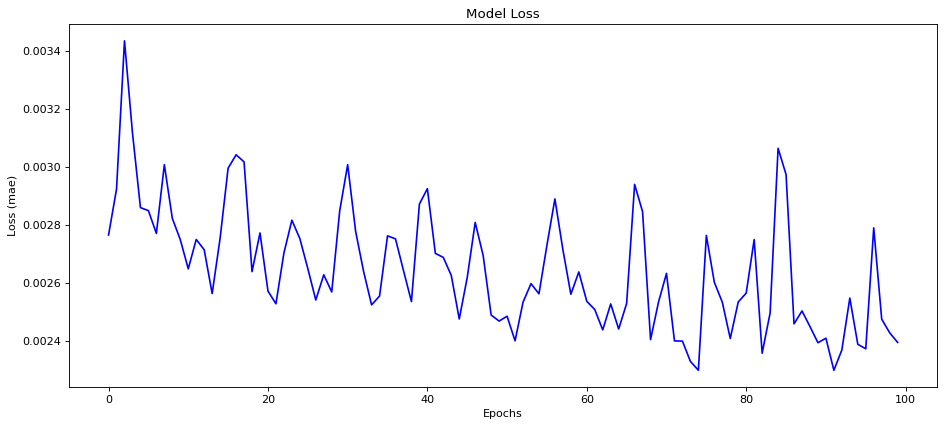

In [110]:
fig, ax = plt.subplots(figsize=(14,6), dpi=80)

ax.plot( history.history['loss'], 'b', label='Train' )
#ax.plot( history.history['val_loss'], 'r', label='Validation' )

ax.set_title('Model Loss')
ax.set_xlabel('Epochs'); ax.set_ylabel('Loss (mae)')

plt.show()

In [20]:
np.zeros(a.shape[0])

array([0., 0., 0., ..., 0., 0., 0.])

In [19]:
np.zeros(a.shape[0]).reshape(-1,1)

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

## 1.데이터프레임 만들고 csv로 저장하기

load 함수
- x데이터 만드는 함수
- 모든 csv파일 불러와서 하나의 data frame으로 저장함 (변수: df)

label 함수
- y데이터 만드는 함수
- 각 csv파일 개수 가져와서 고장유형을 라벨링하는 array로 저장함 (변수: arr)
- 정상(0), 베어링불량(1), 벨트느슨함(2), 축정렬불량(3), 회전체불평형(4)

corv 파라미터
- current 또는 vibration

xc, yc, xv, yv 변수
- current와 vibration의 x데이터와 y데이터


In [ ]:
def load(corv):
  if corv not in ['current','vibration']: return None
  df=pd.DataFrame() 
  i=1 
  for machine in os.listdir(file_path+corv+'/2.2kW'):
      for types in os.listdir(file_path+corv+'/2.2kW/'+machine):
        for files in os.listdir(file_path+corv+'/2.2kW/'+machine+'/'+types):
          tmp=pd.read_csv(file_path+corv+'/2.2kW/'+machine+'/'+types+'/'+files, skiprows=9, header=None)
          if corv=='current': tmp=tmp.drop([0, 4],axis=1)
          elif corv=='vibration': tmp=tmp.drop([0, 2],axis=1)
          tmp=tmp.transpose()
          df=pd.concat([df, tmp])
          if i==1:
            res=machine+' '+types 
            print(i, res)
          elif res!=machine+' '+types: 
            res=machine+' '+types
            print(i, res)
          i+=1
  df=df.reset_index().drop(['index'], axis=1) 
  return df


def label(corv):
  if corv not in ['current','vibration']: return None
  i=0
  for machine in os.listdir(file_path+corv+'/2.2kW'):
    for types in os.listdir(file_path+corv+'/2.2kW/'+machine):
      types=unicodedata.normalize('NFC', types)
      mylen=len(os.listdir(file_path+corv+'/2.2kW/'+machine+'/'+types))
      if corv=='current': mylen*=3
      if types=='정상': tmp=np.zeros(mylen) 
      elif '베어링' in types: tmp=np.ones(mylen)*1 
      elif '벨트' in types: tmp=np.ones(mylen)*2
      elif '축' in types: tmp=np.ones(mylen)*3
      elif '회전체' in types: tmp=np.ones(mylen)*4
      if i==0: arr=tmp
      else: arr=np.hstack([arr,tmp])
      i+=1
  return arr

In [ ]:
xc=load('current'); yc=label('current')
xv=load('vibration'); yv=label('vibration')

1 L-DSF-01 축정렬불량
365 L-DSF-01 정상
462 L-SF-04 정상
539 L-SF-04 베어링불량
739 L-EF-04 회전체불평형
968 L-EF-04 정상
1635 R-EF-05 벨트느슨함
1821 R-EF-05 정상
1 L-EF-04 정상
421 L-EF-04 회전체불평형
626 R-EF-05 벨트느슨함
819 R-EF-05 정상
895 L-SF-04 정상
979 L-SF-04 베어링불량
1219 L-DSF-01 축정렬불량
1426 L-DSF-01 정상


In [ ]:
xc.to_csv('/content/gdrive/MyDrive/CURRENT.csv')
xv.to_csv('/content/gdrive/MyDrive/VIBRATION.csv')

In [ ]:
xc.head()

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,3.042969,3.243164,3.323242,3.443359,3.042969,2.522461,1.881836,1.281250,0.800781,0.400391,...,-2.562500,-1.961914,-1.441406,-1.000977,-0.600586,0.040039,0.800781,1.601562,2.242188,2.642578
1,-1.361328,-2.082031,-2.562500,-2.962891,-2.962891,-2.922852,-3.042969,-3.042969,-2.962891,-2.882812,...,2.722656,2.842773,2.842773,2.842773,2.762695,2.242188,1.641602,1.081055,0.520508,0.120117
2,-2.762695,-2.242188,-1.641602,-1.161133,-0.640625,0.080078,0.960938,1.721680,2.242188,2.682617,...,-0.480469,-1.321289,-1.961914,-2.602539,-3.042969,-3.163086,-3.363281,-3.683594,-3.843750,-3.883789
3,3.283203,3.042969,2.522461,1.921875,1.361328,0.880859,0.480469,-0.120117,-0.800781,-1.601562,...,-0.760742,-0.320312,0.320312,1.081055,1.921875,2.402344,2.802734,2.922852,2.922852,3.042969
4,-2.882812,-2.922852,-2.882812,-2.882812,-2.922852,-2.922852,-2.882812,-2.362305,-1.721680,-1.161133,...,2.842773,2.682617,2.041992,1.441406,0.760742,0.320312,0.000000,-0.520508,-1.041016,-1.721680


In [ ]:
print("x데이터 구조:", xc.shape, xv.shape)
print("y데이터 분포:", len(yc), '->', [list(yc).count(i) for i in range(5)])
print("             ", len(yv), '->', [list(yv).count(i) for i in range(5)])

x데이터 구조: (5655, 2000) (1525, 12000)
y데이터 분포: 5655 -> [2718, 600, 558, 1092, 687]
              1525 -> [680, 240, 193, 207, 205]


## 2-1.y데이터

In [ ]:
def label(corv):
  if corv not in ['current','vibration']: return None
  i=0
  for machine in os.listdir(file_path+corv+'/2.2kW'):
    for types in os.listdir(file_path+corv+'/2.2kW/'+machine):
      types=unicodedata.normalize('NFC', types)
      mylen=len(os.listdir(file_path+corv+'/2.2kW/'+machine+'/'+types))
      if corv=='current': mylen*=3

      if types=='정상': tmp=np.zeros(mylen)
      elif '베어링' in types: tmp=np.ones(mylen)*1
      elif '벨트' in types: tmp=np.ones(mylen)*2
      elif '축' in types: tmp=np.ones(mylen)*3
      elif '회전체' in types: tmp=np.ones(mylen)*4
      if i==0: arr=tmp
      else: arr=np.hstack([arr,tmp])
      i+=1
  return arr

yc=label('current')
yv=label('vibration')

## 2-2.x데이터 불러와서 split하고 pickle로 저장하기(일단 전류만)

In [ ]:
#데이터프레임 다시 불러오기
raw=pd.read_csv('/content/gdrive/MyDrive/CURRENT.csv', index_col=0)

#라벨 추가하기
raw['label']=pd.DataFrame(yc)

#데이터셋 훈련, 검증, 테스트 분리하기
train, valid = train_test_split(raw, test_size=0.40, random_state=0, shuffle=True)
valid, test = train_test_split(valid, test_size=0.50, random_state=0, shuffle=True)

#데이터셋 x와 y 분리하기
train_x=train.iloc[:,:-1] #모든행, 라벨은 빼고
valid_x=valid.iloc[:,:-1]
test_x=test.iloc[:,:-1]
train_y=pd.DataFrame(train.iloc[:,-1]) #모든행, 라벨만
valid_y=pd.DataFrame(valid.iloc[:,-1])
test_y=pd.DataFrame(test.iloc[:,-1])

#피클로 저장하기
train_x.to_pickle(os.path.join(drive, 'xtrain.pkl')) #x피클
valid_x.to_pickle(os.path.join(drive, 'xvalid.pkl'))
test_x.to_pickle(os.path.join(drive, 'xtest.pkl'))
train_y.to_pickle(os.path.join(drive, 'ytrain.pkl')) #y피클
valid_y.to_pickle(os.path.join(drive, 'yvalid.pkl'))
test_y.to_pickle(os.path.join(drive, 'ytest.pkl'))

In [ ]:
print('Train:', train.shape, '->', train_x.shape, train_y.shape)
print('Valid:', valid.shape, '->', valid_x.shape, valid_y.shape)
print('Test :', test.shape, '->', test_x.shape, test_y.shape)

Train: (3393, 2001) -> (3393, 2000) (0, 1)
Valid: (1131, 2001) -> (1131, 2000) (0, 1)
Test : (1131, 2001) -> (1131, 2000) (0, 1)


In [ ]:
raw

,0,1,2,3,4,5,6,7,8,9,...,1991,1992,1993,1994,1995,1996,1997,1998,1999,label
0,3.042969,3.243164,3.323242,3.443359,3.042969,2.522461,1.881836,1.281250,0.800781,0.400391,...,-1.961914,-1.441406,-1.000977,-0.600586,0.040039,0.800781,1.601562,2.242188,2.642578,3.0
1,-1.361328,-2.082031,-2.562500,-2.962891,-2.962891,-2.922852,-3.042969,-3.042969,-2.962891,-2.882812,...,2.842773,2.842773,2.842773,2.762695,2.242188,1.641602,1.081055,0.520508,0.120117,3.0
2,-2.762695,-2.242188,-1.641602,-1.161133,-0.640625,0.080078,0.960938,1.721680,2.242188,2.682617,...,-1.321289,-1.961914,-2.602539,-3.042969,-3.163086,-3.363281,-3.683594,-3.843750,-3.883789,3.0
3,3.283203,3.042969,2.522461,1.921875,1.361328,0.880859,0.480469,-0.120117,-0.800781,-1.601562,...,-0.320312,0.320312,1.081055,1.921875,2.402344,2.802734,2.922852,2.922852,3.042969,3.0
4,-2.882812,-2.922852,-2.882812,-2.882812,-2.922852,-2.922852,-2.882812,-2.362305,-1.721680,-1.161133,...,2.682617,2.041992,1.441406,0.760742,0.320312,0.000000,-0.520508,-1.041016,-1.721680,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5650,2.522461,1.961914,1.561523,1.000977,0.600586,0.040039,-0.640625,-1.321289,-1.641602,-2.082031,...,0.120117,0.600586,1.081055,1.521484,1.921875,2.322266,2.522461,2.562500,2.522461,0.0
5651,-2.882812,-3.042969,-3.083008,-3.002930,-2.882812,-2.762695,-2.602539,-1.961914,-1.561523,-1.081055,...,1.961914,1.561523,1.201172,0.760742,0.280273,-0.280273,-0.800781,-1.241211,-1.601562,0.0
5652,-2.602539,-2.242188,-1.921875,-1.561523,-1.121094,-0.600586,0.000000,0.640625,1.121094,1.561523,...,-1.561523,-1.961914,-2.402344,-2.762695,-2.922852,-3.163086,-3.163086,-3.163086,-2.922852,0.0
5653,2.162109,2.402344,2.562500,2.682617,2.722656,2.522461,2.242188,1.921875,1.401367,1.081055,...,-1.801758,-1.361328,-0.960938,-0.480469,0.240234,0.840820,1.521484,1.921875,2.242188,0.0


In [ ]:
train_x

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
3357,3.563477,3.803711,3.603516,3.683594,3.643555,3.443359,3.243164,2.802734,1.921875,1.081055,...,-3.563477,-2.842773,-1.921875,-1.241211,-0.400391,0.040039,0.760742,1.761719,2.642578,3.123047
1359,0.000000,0.480469,1.281250,1.921875,2.362305,2.682617,2.682617,2.682617,2.842773,2.882812,...,-2.922852,-3.042969,-3.083008,-3.163086,-2.922852,-2.482422,-1.961914,-1.281250,-0.840820,-0.400391
3416,-0.920898,-1.681641,-2.522461,-2.962891,-3.363281,-3.603516,-3.803711,-3.883789,-3.723633,-3.563477,...,3.683594,3.523438,3.323242,3.083008,2.362305,1.761719,0.960938,0.480469,0.000000,-0.680664
5213,-3.643555,-3.523438,-3.323242,-3.163086,-2.762695,-2.001953,-1.481445,-0.760742,-0.320312,0.280273,...,0.440430,-0.160156,-0.640625,-1.361328,-2.202148,-3.083008,-3.243164,-3.563477,-3.843750,-3.723633
3229,1.641602,0.880859,0.120117,-0.480469,-1.201172,-2.041992,-2.962891,-3.363281,-3.643555,-4.083984,...,3.042969,3.403320,3.563477,3.923828,4.324219,4.244141,3.963867,3.483398,3.243164,2.602539
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4931,-3.483398,-3.363281,-3.203125,-3.203125,-2.802734,-2.282227,-1.721680,-1.041016,-0.640625,-0.080078,...,0.760742,0.200195,-0.320312,-0.920898,-1.681641,-2.442383,-3.123047,-3.323242,-3.523438,-3.803711
3264,-1.961914,-2.762695,-3.403320,-3.523438,-3.683594,-4.003906,-4.244141,-4.124023,-3.803711,-3.403320,...,3.843750,3.523438,3.163086,3.042969,2.522461,2.242188,1.121094,0.440430,-0.200195,-0.800781
1653,-3.838745,-4.399292,-4.359253,-4.599487,-4.599487,-4.519409,-3.918823,-3.718628,-2.917847,-2.397339,...,3.047974,2.847778,1.886841,1.366333,0.485474,-0.475464,-1.276245,-2.036987,-2.877808,-3.358276
2607,3.938843,3.898804,3.658569,3.338257,3.178101,2.537476,1.536499,0.695679,-0.025024,-0.545532,...,-2.267212,-1.426392,-0.785767,-0.305298,0.335327,1.136108,2.057007,2.537476,2.857788,3.178101


In [ ]:
train_y

,label
3357,0.0
1359,0.0
3416,0.0
5213,2.0
3229,0.0
...,...
4931,2.0
3264,0.0
1653,1.0
2607,4.0


## pickle 불러오기

pick 함수

- 피클 3개를 한번에 반환하는 함수
- 저장한 피클 불러와서 데이터프레임으로 토치로 변환하고 차원 증가함
- 파라미터로 'X'나 'Y'를 입력


In [ ]:
def pick(xory, tensor=0):
  if xory in ['X','x']: pickles=['xtrain.pkl','xvalid.pkl','xtest.pkl']
  elif xory in ['Y','y']: pickles=['ytrain.pkl','yvalid.pkl','ytest.pkl']
  else: return None
  res=[]
  for i in pickles:
    tmp=pd.read_pickle(os.path.join(drive, i))
    if tensor==0:
      tmp=torch.from_numpy(tmp.values)
      tmp=torch.unsqueeze(tmp, 1)
    res.append(tmp)
  return res[0], res[1], res[2]

In [ ]:
a,b,c=pick('X',1)
x,y,z=pick('Y',1)

In [ ]:
x[x['label']==3].index

Int64Index([ 149,  516,  946,  692,  289,   61,  832,  934,  589,  590,
            ...
             714,  544,  423,  659,  797,  755,   99,  537,  705, 1033],
           dtype='int64', length=679)

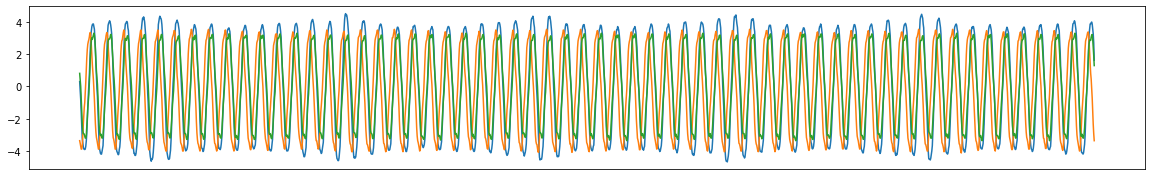

In [ ]:
plt.figure(figsize=(20,3))
i=149
plt.plot(a.iloc[i])
plt.plot(a.iloc[i+1])
plt.plot(a.iloc[i+2])
plt.gca().axes.xaxis.set_visible(False) #x축 이름 제거
plt.show()

In [ ]:
X_train, X_valid, X_test=pick('X')
Y_train, Y_valid, Y_test=pick('Y')

In [ ]:
print('Train:', X_train.shape, Y_train.shape)
print('Valid:', X_valid.shape, Y_valid.shape)
print('Test :', X_test.shape, Y_test.shape)

Train: torch.Size([3393, 1, 2000]) torch.Size([3393, 1])
Valid: torch.Size([1131, 1, 2000]) torch.Size([1131, 1])
Test : torch.Size([1131, 1, 2000]) torch.Size([1131, 1])


# ㅡㅡㅡㅡㅡ 옛날 코드 ㅡㅡㅡㅡㅡ

## 데이터 불러오기

In [ ]:
import numpy as np
import pandas as pd
import os
import unicodedata
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive/')
file_path = "/content/gdrive/MyDrive/data/2020-02-125.기계시설물고장예지_sample/"

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
for machine in os.listdir(file_path+'current/2.2kW'):
    print(machine)

L-DSF-01
L-SF-04
L-EF-04
R-EF-05


In [ ]:
for machine in os.listdir(file_path+'current/2.2kW'):
    print(os.listdir(file_path+'current/2.2kW/'+machine))

['축정렬불량', '정상']
['정상', '베어링불량']
['회전체불평형', '정상']
['벨트느슨함', '정상']


In [ ]:
for machine in os.listdir(file_path+'current/2.2kW'):
  for types in os.listdir(file_path+'current/2.2kW/'+machine):
    print(len(os.listdir(file_path+'current/2.2kW/'+machine+'/'+types)))

364
97
77
200
229
667
186
65


## x데이터

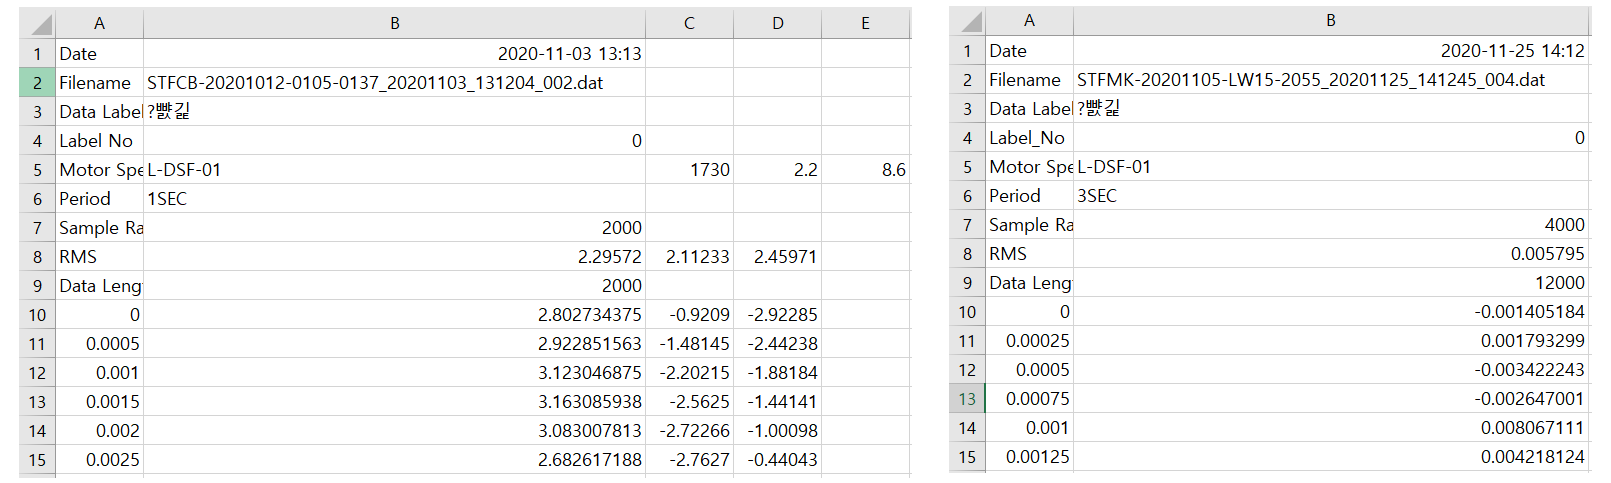

- df: 모든 csv파일 데이터를 담을 최종 data frame임
- - dfc: current
- - dfv: vibration
- i: 몇번째 저장 중인지 알려주는 인덱스임
- machine: 기계이름 가져옴
- types: 고장유형 가져옴
- files: 파일이름 가져옴
- tmp: csv파일 하나를 읽어와서 임시 저정하는 변수임, 9행까지는 skip함, 필요 없는 행 드롭함, 행열 뒤집음
- - dfc에서는 0열과 4열을 삭제
- - dfv에서는 0열과 2열을 삭제
- df: df에 tmp 결합함
- if: 실행확인을 위해 100 단위로 인덱스 출력함

In [ ]:
df=pd.DataFrame()
i=1 

for machine in os.listdir(file_path+'/current/2.2kW'):
  for types in os.listdir(file_path+'/current/2.2kW/'+machine):
    for files in os.listdir(file_path+'/current/2.2kW/'+machine+'/'+types):
      tmp=pd.read_csv(file_path+'/current/2.2kW/'+machine+'/'+types+'/'+files, skiprows=9)
      tmp=tmp.drop(['0','Unnamed: 4'],axis=1)
      tmp=tmp.transpose()
      df=pd.concat([df, tmp])
      if i%100==0: print(i, machine, types)
      i+=1

100 L-DSF-01 축정렬불량
200 L-DSF-01 축정렬불량
300 L-DSF-01 축정렬불량
400 L-DSF-01 정상
500 L-SF-04 정상
600 L-SF-04 베어링불량
700 L-SF-04 베어링불량
800 L-EF-04 회전체불평형
900 L-EF-04 회전체불평형
1000 L-EF-04 정상
1100 L-EF-04 정상
1200 L-EF-04 정상
1300 L-EF-04 정상
1400 L-EF-04 정상
1500 L-EF-04 정상
1600 L-EF-04 정상
1700 R-EF-05 벨트느슨함
1800 R-EF-05 벨트느슨함


In [ ]:
df

,0,1,2,3,4,5,6,7,8,9,...,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998
3.04296875,3.243164,3.323242,3.443359,3.042969,2.522461,1.881836,1.281250,0.800781,0.400391,-0.240234,...,-2.562500,-1.961914,-1.441406,-1.000977,-0.600586,0.040039,0.800781,1.601562,2.242188,2.642578
-1.361328125,-2.082031,-2.562500,-2.962891,-2.962891,-2.922852,-3.042969,-3.042969,-2.962891,-2.882812,-2.322266,...,2.722656,2.842773,2.842773,2.842773,2.762695,2.242188,1.641602,1.081055,0.520508,0.120117
-2.7626953125,-2.242188,-1.641602,-1.161133,-0.640625,0.080078,0.960938,1.721680,2.242188,2.682617,2.842773,...,-0.480469,-1.321289,-1.961914,-2.602539,-3.042969,-3.163086,-3.363281,-3.683594,-3.843750,-3.883789
3.283203125,3.042969,2.522461,1.921875,1.361328,0.880859,0.480469,-0.120117,-0.800781,-1.601562,-2.242188,...,-0.760742,-0.320312,0.320312,1.081055,1.921875,2.402344,2.802734,2.922852,2.922852,3.042969
-2.8828125,-2.922852,-2.882812,-2.882812,-2.922852,-2.922852,-2.882812,-2.362305,-1.721680,-1.161133,-0.640625,...,2.842773,2.682617,2.041992,1.441406,0.760742,0.320312,0.000000,-0.520508,-1.041016,-1.721680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2.5224609375,1.961914,1.561523,1.000977,0.600586,0.040039,-0.640625,-1.321289,-1.641602,-2.082031,-2.602539,...,-0.480469,0.120117,0.600586,1.081055,1.521484,1.921875,2.322266,2.522461,2.562500,2.522461
-2.8828125,-3.042969,-3.083008,-3.002930,-2.882812,-2.762695,-2.602539,-1.961914,-1.561523,-1.081055,-0.600586,...,2.402344,1.961914,1.561523,1.201172,0.760742,0.280273,-0.280273,-0.800781,-1.241211,-1.601562
-2.6025390625,-2.242188,-1.921875,-1.561523,-1.121094,-0.600586,0.000000,0.640625,1.121094,1.561523,2.041992,...,-0.920898,-1.561523,-1.961914,-2.402344,-2.762695,-2.922852,-3.163086,-3.163086,-3.163086,-2.922852
2.162109375,2.402344,2.562500,2.682617,2.722656,2.522461,2.242188,1.921875,1.401367,1.081055,0.600586,...,-2.402344,-1.801758,-1.361328,-0.960938,-0.480469,0.240234,0.840820,1.521484,1.921875,2.242188


In [ ]:
df.to_csv('/content/gdrive/MyDrive/current.csv')

##
## df를 csv로 바꿔서 드라이브에 최종저장하는 것임!!! 한번만 실행!!!
##

## y데이터

- arr: 라벨 데이터를 담을 최종 array임
- mylist: 고장유형이랑 파일개수를 순서대로 저장하는 리스트임
- types: 아래의 오류 때문에 unicode 변환함
- - 오류: 한글이 같은데 == 결과가 false가 나옴, type은 str인데 1로 인덱싱 하니 첫글자가 아니라 자음이 나옴
- - 해결: https://jonsyou.tistory.com/26
- mylen
- for: step을 2로 해서 mylist에서 고장유형만 가져옴
- if: 고장유형이 정상이면 np.zeros()를 써서 0이 파일개수만큼 있는 array를 tmp에 저장함
- elif: 고장유형이 고장이면 np.ones()를 써서 1,2,3,4가 파일개수만큼 있는 array를 tmp에 저장함
-if: 첫번째면 arr에 tmp 대입함 (arr가 없기 때문에 아래 코드 쓰면 오류남)
-else: 아니면 arr에 tmp 이어붙이고 arr에 저장함

In [ ]:
mylist=[]
for machine in os.listdir(file_path+'/current/2.2kW'):
  for types in os.listdir(file_path+'/current/2.2kW/'+machine):
    types=unicodedata.normalize('NFC', types)
    mylen=len(os.listdir(file_path+'/current/2.2kW/'+machine+'/'+types))
    mylist.append(str(types))
    mylist.append(mylen)

print(mylist)

['축정렬불량', 364, '정상', 97, '정상', 77, '베어링불량', 200, '회전체불평형', 229, '정상', 667, '벨트느슨함', 186, '정상', 65]


In [ ]:
for i in range(0,len(mylist),2):
  print(i, mylist[i])
  if mylist[i]=='정상': tmp=np.zeros(mylist[i+1])
  elif '베어링' in mylist[i]: tmp=np.ones(mylist[i+1])*1
  elif '벨트' in mylist[i]: tmp=np.ones(mylist[i+1])*2
  elif '축' in mylist[i]: tmp=np.ones(mylist[i+1])*3
  elif '회전체' in mylist[i]: tmp=np.ones(mylist[i+1])*4
  if i==0: arr=tmp
  else: arr=np.hstack([arr,tmp])

0 축정렬불량
2 정상
4 정상
6 베어링불량
8 회전체불평형
10 정상
12 벨트느슨함
14 정상


In [ ]:
arr[300:600]

array([3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

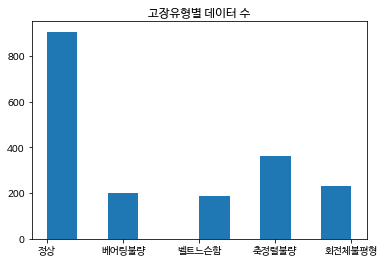

[906, 200, 186, 364, 229]

In [ ]:
plt.hist(list(arr))
plt.rc('font', family='NanumBarunGothic')
plt.title('고장유형별 데이터 수')
plt.xticks(range(5), ['정상','베어링불량','벨트느슨함','축정렬불량','회전체불평형'])
plt.show()

[list(arr).count(i) for i in range(5)]

In [ ]:

X_train, X_test, Y_train, Y_test = train_test_split(df, arr, test_size=0.3, random_state=0)
